In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Caminho para os dados no Google Drive
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

In [ ]:
# Função para extrair MFCCs de um arquivo
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Média dos coeficientes
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

# Carregar dados e rótulos
data = []
labels = []

In [ ]:
def load_data(folder_path, label):
    global data, labels
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        features = extract_features(file_path)
        if features is not None:
            data.append(features)
            labels.append(label)

# Criar as pastas 'real' e 'fake' caso não existam
if not os.path.exists(file_path_real):
    os.makedirs(file_path_real)
if not os.path.exists(file_path_fake):
    os.makedirs(file_path_fake)

# Processar dados
load_data(file_path_fake, 0)  # Rótulo 0 para Fake
load_data(file_path_real, 1)  # Rótulo 1 para Real

In [ ]:
# Remover dados faltantes
data_filtered = []
labels_filtered = []
for i in range(len(data)):
    if data[i] is not None:
        data_filtered.append(data[i])
        labels_filtered.append(labels[i])

data = data_filtered
labels = labels_filtered

In [ ]:
np.random.seed(None)  # Remove o seed fixo
np.random.shuffle(labels)  # Bagunça os rótulos de maneira mais imprevisível

In [ ]:
# Converter para DataFrame
df = pd.DataFrame(data)
df['label'] = labels

# Contar as ocorrências de cada label
label_counts = df['label'].value_counts()

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,label
0,-310.484985,79.589180,12.035122,21.775892,7.463613,-4.327323,1.702638,5.056441,-11.605008,-8.825641,-12.136454,-8.166679,-7.886450,1
1,-257.937653,95.777596,-4.056822,15.742610,8.676238,-1.592806,-4.348527,-4.163268,-6.542841,-6.530914,-14.290150,-11.238543,-4.450969,1
2,-292.760193,85.521347,-18.103905,14.233822,-1.934288,-8.300287,-15.360986,-14.333099,-0.524541,-12.453050,-2.744914,-14.212177,0.993812,1
3,-277.897675,90.807686,-10.502482,11.377957,-5.474428,3.409711,-7.161676,-10.140576,-7.643803,-13.585090,2.786534,-11.668981,4.507519,1
4,-310.633148,127.519531,-15.467380,0.326183,-1.933270,-0.297417,-3.829169,-13.276252,-5.107690,-10.653046,2.168447,-12.386104,6.813177,1


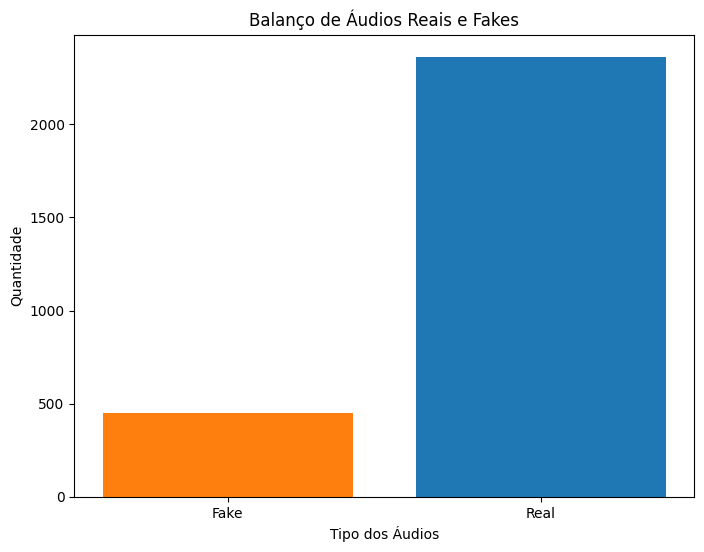

In [ ]:
# Plotando o gráfico
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, tick_label=['Real', 'Fake'], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Tipo dos Áudios')
plt.ylabel('Quantidade')
plt.title('Balanço de Áudios Reais e Fakes')
plt.show()

In [ ]:
df.shape

(2811, 14)

In [ ]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

In [ ]:
# Função para calcular e exibir as métricas
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\n")

In [ ]:
# Dividir em treino e teste
X_train_rf_model, X_test_rf_model, y_train_rf_model, y_test_rf_model = train_test_split(X, y, test_size=0.2, random_state=1)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=1)
rf_model.fit(X_train_rf_model, y_train_rf_model)
rf_pred = rf_model.predict(X_test_rf_model)
print("Random Forest:")
print_metrics(y_test_rf_model, rf_pred)

Random Forest:
Acurácia: 0.73
Precisão: 0.83
Recall: 0.84
F1-Score: 0.83




In [ ]:
# Dividir em treino e teste
X_train_lgb_model, X_test_lgb_model, y_train_lgb_model, y_test_lgb_model = train_test_split(X, y, test_size=0.2, random_state=2)

# 2. LightGBM
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(X_train_lgb_model, y_train_lgb_model)
lgb_pred = lgb_model.predict(X_test_lgb_model)
print("LightGBM:")
print_metrics(y_test_lgb_model, lgb_pred)

LightGBM:
Acurácia: 0.83
Precisão: 0.84
Recall: 0.98
F1-Score: 0.91




In [ ]:
# Dividir em treino e teste
X_train_nb_model, X_test_nb_model, y_train_nb_model, y_test_nb_model = train_test_split(X, y, test_size=0.2, random_state=3)

# 3. Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_nb_model, y_train_nb_model)
nb_pred = nb_model.predict(X_test_nb_model)
print("Naïve Bayes:")
print_metrics(y_test_nb_model, nb_pred)

Naïve Bayes:
Acurácia: 0.85
Precisão: 0.85
Recall: 1.00
F1-Score: 0.92




In [ ]:
# Dividir em treino e teste
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=4)

# Padronização dos dados para LSTM e KNN
scaler = StandardScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train_lstm)
X_test_scaled_lstm = scaler.transform(X_test_lstm)

# 4. LSTM
X_train_lstm = X_train_scaled_lstm.reshape(-1, 1, X_train_scaled_lstm.shape[1])
X_test_lstm = X_test_scaled_lstm.reshape(-1, 1, X_test_scaled_lstm.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(units=1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, verbose=0)
lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int64")
print("LSTM:")
print_metrics(y_test_lstm, lstm_pred)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM:
Acurácia: 0.72
Precisão: 0.84
Recall: 0.82
F1-Score: 0.83




In [ ]:
# Dividir em treino e teste
X_train_knn_model, X_test_knn_model, y_train_knn_model, y_test_knn_model = train_test_split(X, y, test_size=0.2, random_state=5)

# 5. KNN
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_knn_model, y_train_knn_model)
knn_pred = knn_model.predict(X_test_knn_model)
print("KNN:")
print_metrics(y_test_knn_model, knn_pred)

KNN:
Acurácia: 0.64
Precisão: 0.84
Recall: 0.71
F1-Score: 0.77


